In [4]:
import pandas as pd
import numpy as np

rng = np.random.default_rng()

In [170]:
boardSize = 20
numberOfAnts = 10
antScanDistance = 3
gamma1 = 0.7
gamma2 = 0.3


In [164]:
data = pd.read_csv(
    "./Audytorium/sdmt1.txt",
    sep='\t',
    header=None,
    names=['depth', 'value1', 'value2']
)

data.insert(0, 'ID', range(0, 0 + len(data)))

spawnPositions = pd.DataFrame(rng.integers(0, boardSize, size=(len(data.index), 2)), columns=list('xy'))

data = pd.concat([data, spawnPositions], axis=1)

data.insert(6, 'isOnTheGround', True)

data.head()

,ID,depth,value1,value2,x,y,isOnTheGround
0,0,"2,6",335,500,12,7,True
1,1,"2,8",390,650,4,5,True
2,2,3,435,750,5,16,True
3,3,"3,2",385,750,18,1,True
4,4,"3,4",150,450,17,1,True


<AxesSubplot:xlabel='x', ylabel='y'>

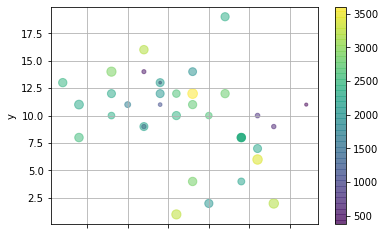

In [190]:
data.plot.scatter(x="x", y="y", s=data["value1"]/20, c=data["value2"], cmap='viridis', alpha=0.5, grid=True)

In [189]:
class Ant:
    def __init__(self):
        self.x = rng.integers(0, boardSize)
        self.y = rng.integers(0, boardSize)
        self.isCarring = False
        self.carriedSeedId = -1

    def tick(self):
        self.move()
        seedId = self.isStandingOnSeed()
        if seedId != -1:
            if not self.isCarring:
                self.pickUpTrial(seedId)
        else:
            if self.isCarring:
                self.dropTrial()

        pass

    def move(self):
        # TODO: Needs improvement - ant is generally constantly in the same region 
        deltaX = rng.integers(-1, 2)
        deltaY = rng.integers(-1, 2)

        newX = self.x + deltaX
        if(newX >= 0 and newX < boardSize):
            self.x = newX

        newY = self.y + deltaY
        if(newY >= 0 and newY < boardSize):
            self.y = newY
        pass

    def isStandingOnSeed(self):
        i = 0
        for x, y in zip(data['x'], data['y']):
            if (x == self.x) and (y == self.y):
                if (data['isOnTheGround'][i]):
                    return i
            i += 1
        return -1

    def scanEnvironment(self):
        closeSeeds = []

        i = 0
        for x, y in zip(data['x'], data['y']):
            if (x > self.x - antScanDistance) and (x < self.x + antScanDistance):
                if (y > self.y - antScanDistance) and (y < self.y + antScanDistance):
                    closeSeeds.append(i)
            i += 1

        return closeSeeds

    def pickUpTrial(self, id):
        localDensity = len(self.scanEnvironment()) / len(data.index)
        propability = (gamma1 / (gamma1 + localDensity)) ** 2
        if(propability > rng.random()):
            self.pickUp(id)
        pass

    def pickUp(self, id):
        data['isOnTheGround'][id] = False
        self.isCarring = True
        self.carriedSeedId = id
        pass


    def dropTrial(self):
        localDensity = len(self.scanEnvironment()) / len(data.index)
        propability = (localDensity / (gamma2 + localDensity)) ** 2
        if(propability > rng.random()):
            self.drop()
        pass

    def drop(self):
        data['isOnTheGround'][self.carriedSeedId] = True
        data['x'][self.carriedSeedId] = self.x
        data['y'][self.carriedSeedId] = self.y

        self.isCarring = False
        self.carriedSeedId = -1
        pass

ants = []

for i in range(0, numberOfAnts):
    ants.append(Ant())

for i in range(0, 1000):
    for ant in ants:
        ant.tick()


    # print(ant.x, ant.y)
    # ant.scanEnvironment()
    

